In [170]:
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")

# 
bin_data_names = ['twitter-hate-speech-tsa', 'civil-comments', 'gibert-2018-shs', 'us-election-2020', 'cmsb-tsd']
multi_class_data_names = ['founta-2018-thas', 'davidson-thon', 'ami']
eval_data_names = bin_data_names + multi_class_data_names

eval_data_names = ['civil-comments', 'civil-comments-5k-7p5', 'civil-comments-20k', 'civil-comments-40k']

data_cols = ["data_name", "num_classes", "data_type", "size", "rho", "distribution"]
variant_cols = ['variant', 'sampling_modifiedRS_rho', 'sampling_weightedRS_percentage', 'augmentation_rho', 'augmentation_percentage', 'augmentation_top_k', 'wce_alpha', 'fl_gamma', "augmentation_bert_top_k"]
metric_suffices = ['f1_macro', 'f1_per_label_0', 'f1_per_label_1', 'f1_per_label_2', 'f1_per_label_3', 'f1_per_label_4', 'accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'auprc']
metrics_cols = [f'train_{suffix}' for suffix in metric_suffices] + [f'val_{suffix}' for suffix in metric_suffices] + [f'test_{suffix}' for suffix in metric_suffices]
cols_raw = data_cols + variant_cols + ['pl_seed'] + metrics_cols + ["best_epoch"] + ['mlflow_run_id']

cols_seeds_mean = data_cols + variant_cols[:-1] + ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std'] + [metric for metric in metrics_cols if metric not in ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std']]

results_excel_path = "results_all.xlsx"
cols_results = data_cols + variant_cols[:-1] + ['test_f1_macro', 'test_f1_macro_std']

In [174]:
data2distribution = {}
data2size = {}
data2rho = {}

def read_from_csv(data_name, header=0, names=None):
    if "tsv" in data_name:
        data = pd.read_csv(data_name,
                            sep='\t',
                            encoding = "utf-8",
                            engine = "python",
                            header = header,
                            names = names)
    elif "csv" in data_name:
        data = pd.read_csv(data_name,
                        encoding = "utf-8",
                        engine = "python",
                        header = header,
                        names = names)
    else:
        raise NotImplementedError("Given data file type is not supported yet.")
    return data
def get_data_info_by_data_name(data_name, label_col, category2label, train_filename, val_filename=None, test_filename=None):
    data = read_from_csv(f"./data/{data_name}/{train_filename}")
    label_counts = data[label_col].value_counts()
    if val_filename:
        val_data = read_from_csv(f"./data/{data_name}/{val_filename}")
        label_counts += val_data[label_col].value_counts()
    if test_filename:
        test_data = read_from_csv(f"./data/{data_name}/{test_filename}")
        label_counts += test_data[label_col].value_counts()
    data2size[data_name] = sum(label_counts.values)
    data2distribution[data_name] = {f"{label}_{cat}": round(label_counts[label]/data2size[data_name], 3) for cat, label in category2label.items()}
    data2rho[data_name] = round(max(label_counts.values) / min(label_counts.values), 2)

# get_data_info_by_data_name("bretschneider-th-main", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("twitter-hate-speech-tsa", "label", {"non-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-5k-7p5", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-20k", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-40k", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
# get_data_info_by_data_name("bretschneider-th-school", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("gibert-2018-shs", "label", {"no-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("us-election-2020", "label", {"non-HOF": 0, "HOF": 1}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("cmsb-tsd", "label", {"non-sexist": 0, "sexist": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("founta-2018-thas", "label_multi", {"normal": 0, "spam": 1, "abusive": 2, "hateful": 3}, "data_clean.csv")
get_data_info_by_data_name("ami", "label_multi", {"discredit": 0, "stereotype": 1, "dominance": 2, "sexual harassment": 3, "derailing": 4}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("davidson-thon", "label_multi", {"hate speech": 0, "offensive language": 1, "neither": 2}, "data_clean.csv")

# get_data_info_by_data_name("gao-2018-fhc", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=5.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=10.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=15.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=20.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")

# get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=5.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=10.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=15.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=20.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")


data_name_orig2display = {'twitter-hate-speech-tsa': 'Twitter-Hate-Speech', 
                            'civil-comments': 'Civil-Comments', 
                            'civil-comments-20k': 'Civil-Comments-20k', 
                            'civil-comments-40k': 'Civil-Comments-40k',
                            'civil-comments-5k-7p5': 'Civil-Comments-5k-7p5',
                            'gibert-2018-shs': 'Gibert-2018', 
                            'us-election-2020': 'US-Election-2020', 
                            'cmsb-tsd': 'CMSB', 
                            'waseem-and-hovy-2016': 'Waseem-and-Hovy-2016',
                            'founta-2018-thas': 'Founta-2018', 
                            'davidson-thon': 'Davidson-2017', 
                            'ami': 'AMI-2018'}

for data_name in eval_data_names:
    print(f"{data_name_orig2display[data_name]}\t{data2size[data_name]}\t{data2distribution[data_name]}\t{data2rho[data_name]}")

Civil-Comments	5000	{'0_non-toxic': 0.92, '1_toxic': 0.08}	11.53
Civil-Comments-5k-7p5	5006	{'0_non-toxic': 0.883, '1_toxic': 0.117}	7.51
Civil-Comments-20k	20000	{'0_non-toxic': 0.919, '1_toxic': 0.081}	11.35
Civil-Comments-40k	40000	{'0_non-toxic': 0.92, '1_toxic': 0.08}	11.53


In [175]:
def get_value_by_run_id(data_dir, run_id, key):
    value = None
    for root, _, files in os.walk(data_dir + run_id):
        if key in files:
            with open(f"{root}/{key}", "r") as f:
                value = f.readlines()[-1]
                if "train" in key or "val" in key or "test" in key:
                    value = value.split()[1]
                if value == "sampling_modifiedRS": # Forgot to specify in the variant value
                    value += "_oversampling"
                if value == "sampling_weightedRS":
                    value += "_combi"
                if "tensor" in value:
                    value = "-"
                try:
                    value = ast.literal_eval(value)
                    if isinstance(value, list):
                        value = [round(v, 2) for v in value]
                        value = tuple(value)
                except (ValueError, SyntaxError):
                    pass
                break
    if value is None:
        value = "-"
        if "train" in key or "val" in key or "test" in key:
            if "per_label" in key:
                value = 0
            else:
                raise RuntimeError(f"This run log {data_dir + run_id} does not have test metrics. ")
    return value

def get_best_epoch_by_run_id(data_dir, run_id):
    ckpt_dir = f"{data_dir}{run_id}/artifacts/model_checkpoints/"
    ckpt = os.listdir(ckpt_dir)[0]
    epoch = ast.literal_eval(ckpt.split("epoch=")[1][1:2])
    return epoch

def get_log_by_data_name(data_name):
    data_runs_dir = f'./logs/{data_name}/'
    run_ids = os.listdir(data_runs_dir)
    rows = []
    for run_id in run_ids:
        run_result = {col_name: get_value_by_run_id(data_runs_dir, run_id, col_name) for col_name in cols_raw[:-2]}
        run_result['best_epoch'] = get_best_epoch_by_run_id(data_runs_dir, run_id)
        run_result['mlflow_run_id'] = run_id
        rows.append(run_result)
    df = pd.DataFrame(columns=cols_raw, data=rows)
    #  - add wfl(alpha=1.0) => fl
    df.loc[(df["variant"] == "wfl") & (df["wce_alpha"] == "-"),  "variant"] = "fl" 
    #  - combine these two columns
    def fix_aug_top_k(row):
        if row["augmentation_top_k"] != "-" or row["augmentation_bert_top_k"] != "-":
            if row["augmentation_top_k"] != "-":
                return row["augmentation_top_k"]
            else:
                return row["augmentation_bert_top_k"]
        else:
            return "-"
    df["augmentation_top_k"] = df.apply(lambda row: fix_aug_top_k(row), axis=1)
    df = df.drop('augmentation_bert_top_k', axis=1)
    return df

def aggregate_results(data_name, writer):
    # Get raw mlflow logs:
    df = get_log_by_data_name(data_name)
    df.to_excel(writer, sheet_name=f"{data_name}_raw")
    assert len(df) % 3 == 0
    # Aggregate results from 3 seeds
    agg_target = {metric: 'mean' for metric in metrics_cols}
    agg_target.update({col: 'first' for col in data_cols})
    df['test_f1_macro_std'] = df.loc[:, 'test_f1_macro']
    agg_target.update({'test_f1_macro_std': 'std'})
    df_seeds_mean = df.groupby(variant_cols[:-1], as_index=False).agg(agg_target)
    #  - change metric to be 00.00
    for metric in metrics_cols + ['test_f1_macro_std']:
        df_seeds_mean[metric] = df_seeds_mean[metric].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
    
    #  - re-order the columns
    df_seeds_mean.loc[:, "size"] = [data2size[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "distribution"] = [data2distribution[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "rho"] = [data2rho[data_name]] * len(df_seeds_mean)
    
    df_seeds_mean = df_seeds_mean[cols_seeds_mean]
    df_seeds_mean.to_excel(writer, sheet_name=f"{data_name}_seeds-mean")
    df_val_f1_max = df_seeds_mean.loc[df_seeds_mean.groupby(["variant"])['val_f1_macro'].idxmax()].reset_index(drop=True)
    return df, df_seeds_mean, df_val_f1_max

In [176]:
data_names = eval_data_names

writer = pd.ExcelWriter(results_excel_path)
df_all_raw_results = pd.DataFrame(columns=cols_raw)
df_all_mean_results = pd.DataFrame(columns=cols_seeds_mean)
df_all_agg_results = pd.DataFrame(columns=cols_results)
for data_name in data_names:
    print(f"Extracting logs for {data_name} ...")
    df, df_seeds_mean, df_val_f1_max = aggregate_results(data_name, writer)
    df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
    df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
    df_all_agg_results = pd.concat([df_all_agg_results, df_val_f1_max], ignore_index=True)
df_all_raw_results.to_csv("results/raw_results.csv", index=False)
df_all_mean_results.to_csv("results/mean_results.csv", index=False)
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
df_all_agg_results.to_excel(writer, sheet_name=f"best_of_all")

variants = df_all_agg_results.variant.unique()
df_table = pd.DataFrame(columns=data_names)
for variant in variants:
    for data_name in data_names:
        condition = (df_all_agg_results["variant"] == variant) & (df_all_agg_results["data_name"] == data_name)
        if len(df_all_agg_results[condition]) > 0:
            df_table.loc[variant, data_name] = f"{df_all_agg_results[condition]["test_f1_macro"].values[0]} ({df_all_agg_results[condition]["test_f1_macro_std"].values[0]})"
df_table = df_table.reindex(["baseline", 
                    "sampling_modifiedRS_oversampling", "sampling_modifiedRS_undersampling", "sampling_weightedRS_combi", 
                    "augmentation_bert", 
                    "th", "wce", "fl", "wfl",
                    "augmentation_abusive_lexicon", "augmentation_external_data", ])

df_table.to_excel(writer, sheet_name=f"Table")
writer.close()

Extracting logs for civil-comments ...


/tmp/ipykernel_2685133/1044286280.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
/tmp/ipykernel_2685133/1044286280.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
/tmp/ipykernel_2685133/1044286280.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, 

Extracting logs for civil-comments-5k-7p5 ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Extracting logs for civil-comments-20k ...
Extracting logs for civil-comments-40k ...


In [177]:
df_table

,civil-comments,civil-comments-5k-7p5,civil-comments-20k,civil-comments-40k
baseline,75.99 (0.46),78.95 (2.16),79.19 (1.24),79.22 (0.55)
sampling_modifiedRS_oversampling,75.85 (2.6),80.3 (0.76),79.07 (1.56),NaN
sampling_modifiedRS_undersampling,73.97 (2.66),81.46 (1.53),78.73 (1.7),79.21 (0.35)
sampling_weightedRS_combi,73.12 (1.76),NaN,NaN,NaN
augmentation_bert,75.88 (1.43),NaN,NaN,NaN
th,75.27 (2.12),79.47 (0.36),77.66 (1.14),77.73 (0.25)
wce,73.55 (0.54),NaN,NaN,NaN
fl,76.75 (0.91),79.05 (0.42),78.83 (1.31),NaN
wfl,73.45 (3.04),NaN,NaN,NaN
augmentation_abusive_lexicon,75.67 (0.96),78.98 (0.94),78.09 (0.62),NaN


## Std

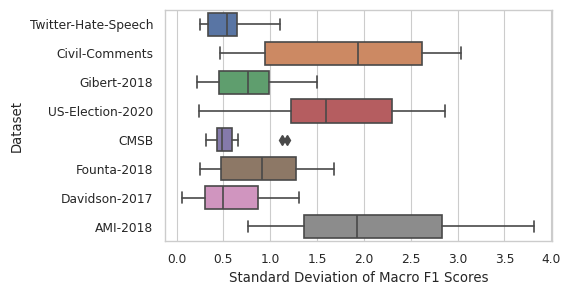

In [101]:
fig, ax = plt.subplots(figsize=(5,3))
df_std = df_all_agg_results[["data_name", "test_f1_macro_std"]]
df_std = df_std.rename({"data_name":"Dataset", "test_f1_macro_std":"Standard Deviation of Macro F1 Scores"}, axis=1)
df_std["Dataset"] = df_std['Dataset'].map(data_name_orig2display)
data_order = [data_name_orig2display[data_name] for data_name in data_names]
sns.boxplot(x="Standard Deviation of Macro F1 Scores", y="Dataset", data=df_std, order=data_order)
ax.set_xticks([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
ax.figure.savefig('std_distribution.svg', dpi=600, bbox_inches="tight")

## Plot results

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context("paper")

In [205]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### Random Oversampling

#### Overfitting

In [146]:
rho_name = "sampling_modifiedRS_rho"
data_clear_overfitting = ["founta-2018-thas", "davidson-thon"]
which_data_to_check = (df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])) & (df_all_mean_results["data_name"].isin(data_clear_overfitting))
df_overfitting = df_all_mean_results[which_data_to_check][["data_name", rho_name, "train_f1_macro", "val_f1_macro", "test_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting[rho_name] == "-")
    baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
for split in ["train", "val", "test"]:
    df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
df_overfitting = df_overfitting[df_overfitting[rho_name] != "-"]
df_overfitting = df_overfitting[[rho_name, "data_name", "train_f1_macro_delta", "val_f1_macro_delta", "test_f1_macro_delta"]]
df_overfitting

,sampling_modifiedRS_rho,data_name,train_f1_macro_delta,val_f1_macro_delta,test_f1_macro_delta
550,1.0,founta-2018-thas,3.69,-1.69,-1.09
551,2.0,founta-2018-thas,2.43,-0.72,0.01
552,3.0,founta-2018-thas,2.11,-0.21,0.04
553,5.0,founta-2018-thas,-0.38,0.21,1.07
554,7.5,founta-2018-thas,-0.41,0.35,0.92
555,10.0,founta-2018-thas,-2.29,0.76,1.28
556,15.0,founta-2018-thas,-1.73,0.06,0.90
646,1.0,davidson-thon,5.90,0.82,0.72
647,2.0,davidson-thon,5.74,1.46,-0.19
648,3.0,davidson-thon,4.91,1.35,0.17


In [22]:
# rho_name = "augmentation_rho"
# data_clear_overfitting = ["civil-comments", "davidson-thon"]
# which_data_to_check = (df_all_mean_results["variant"].isin(["baseline", "augmentation_external_data"])) & (df_all_mean_results["data_name"].isin(data_clear_overfitting))
# df_overfitting = df_all_mean_results[which_data_to_check][["data_name", rho_name, "train_f1_macro", "val_f1_macro", "test_f1_macro"]]
# def compute_deviation_to_baseline(row, split):
#     baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting[rho_name] == "-")
#     baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
#     return row[f"{split}_f1_macro"] - baseline_value
# for split in ["train", "val", "test"]:
#     df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
# df_overfitting = df_overfitting[df_overfitting[rho_name] != "-"]
# df_overfitting = df_overfitting[[rho_name, "data_name", "train_f1_macro_delta", "val_f1_macro_delta", "test_f1_macro_delta"]]
# df_overfitting

,augmentation_rho,data_name,train_f1_macro_delta,val_f1_macro_delta,test_f1_macro_delta
137,1.0,civil-comments,1.18,0.02,1.05
138,2.0,civil-comments,1.09,1.31,0.45
139,3.0,civil-comments,0.92,0.39,0.54
140,5.0,civil-comments,0.27,0.86,-0.18
141,7.5,civil-comments,0.67,0.15,-0.83
632,1.0,davidson-thon,5.00,-1.28,-1.63
633,2.0,davidson-thon,4.69,-1.64,-2.07
634,3.0,davidson-thon,4.72,-1.03,-1.17
635,5.0,davidson-thon,2.84,0.26,-0.53
636,7.5,davidson-thon,2.49,-1.63,-1.31


In [147]:
df_overfitting_expanded = pd.DataFrame(columns=[rho_name, "data_name", "split", "f1_delta"])
rhos_unique = df_overfitting[rho_name].unique().tolist()[:-1]
data_names_unique = df_overfitting.data_name.unique().tolist()
data_names_list = []
for data_name in data_names_unique:
    data_names_list += [data_name_orig2display[data_name]] * 3 * len(rhos_unique)
df_overfitting_expanded["data_name"] = data_names_list
rhos_list = []
for rho in rhos_unique:
    rhos_list += [rho] * 3
df_overfitting_expanded[rho_name] = rhos_list * len(data_names_unique)
splits = ["train", "val", "test"]
df_overfitting_expanded["split"] = splits * len(rhos_unique) * len(data_names_unique)
for data_name in data_names_unique:
    for split in splits:
        for rho in rhos_unique:
            where_to_assign = ((df_overfitting_expanded["data_name"] == data_name_orig2display[data_name]) 
                                & (df_overfitting_expanded["split"] == split)
                                & (df_overfitting_expanded[rho_name] == rho))
            value_from_where = ((df_overfitting["data_name"] == data_name)
                                & (df_overfitting[rho_name] == rho))
            if len(df_overfitting[value_from_where]) > 0:
                value = df_overfitting.loc[value_from_where, f"{split}_f1_macro_delta"].values[0]
                df_overfitting_expanded.loc[where_to_assign, "f1_delta"] = value
df_overfitting_expanded = df_overfitting_expanded.rename({"data_name":"Dataset", "split":"Split"}, axis=1)
df_overfitting_expanded

,sampling_modifiedRS_rho,Dataset,Split,f1_delta
0,1.0,Founta-2018,train,3.69
1,1.0,Founta-2018,val,-1.69
2,1.0,Founta-2018,test,-1.09
3,2.0,Founta-2018,train,2.43
4,2.0,Founta-2018,val,-0.72
5,2.0,Founta-2018,test,0.01
6,3.0,Founta-2018,train,2.11
7,3.0,Founta-2018,val,-0.21
8,3.0,Founta-2018,test,0.04
9,5.0,Founta-2018,train,-0.38


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


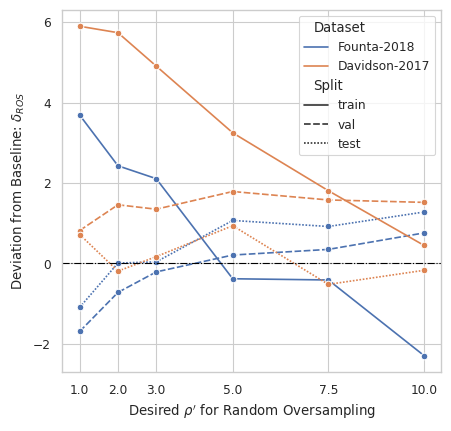

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.6,4.4))
sns.lineplot(x=rho_name, y="f1_delta", data=df_overfitting_expanded, 
                hue="Dataset", style="Split", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r'Deviation from Baseline: $\delta_{ROS}$')
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/ROS_overfitting.svg', dpi=600, bbox_inches="tight")

#### Changes with rho

In [154]:
rho_name = "sampling_modifiedRS_rho"
data_clear_ros = ["us-election-2020", "cmsb-tsd", "founta-2018-thas"]
which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])) 
                        & ~(df_all_mean_results["data_name"].isin(data_clear_ros))
                        )
df_ros = df_all_mean_results[which_data_to_check][["data_name", rho_name, "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_ros["data_name"] == row["data_name"]) & (df_ros[rho_name] == "-")
    baseline_value = df_ros.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_ros["val_f1_macro_delta"] = df_ros.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_ros = df_ros[df_ros[rho_name] != "-"]
df_ros = df_ros[[rho_name, "data_name", "val_f1_macro_delta"]]
df_ros = df_ros.rename({"data_name":"Dataset"}, axis=1)
df_ros["Dataset"] = df_ros['Dataset'].map(data_name_orig2display)
rhos_unique = df_ros.sampling_modifiedRS_rho.unique().tolist()
df_ros

,sampling_modifiedRS_rho,Dataset,val_f1_macro_delta
45,1.0,Twitter-Hate-Speech,-0.30
46,2.0,Twitter-Hate-Speech,-0.58
47,3.0,Twitter-Hate-Speech,-0.09
48,5.0,Twitter-Hate-Speech,-0.14
49,7.5,Twitter-Hate-Speech,0.16
50,10.0,Twitter-Hate-Speech,-0.22
150,1.0,Civil-Comments,-1.14
151,2.0,Civil-Comments,-0.34
152,3.0,Civil-Comments,-0.01
153,5.0,Civil-Comments,0.59


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


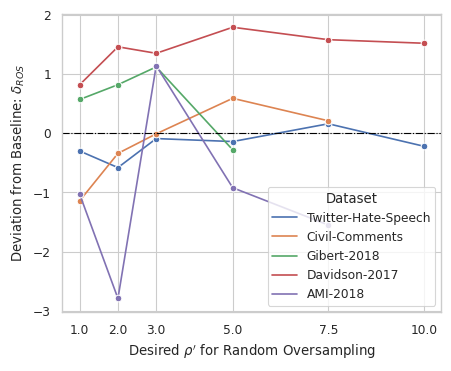

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.6,3.8)) # 
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_ros, 
                hue="Dataset", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r"Deviation from Baseline: $\delta_{ROS}$")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/ROS_trend.svg', dpi=600, bbox_inches="tight")

## Random Undersampling

In [157]:
data_noclear_lossinfo_imbalance = ["us-election-2020", "cmsb-tsd", "founta-2018-thas"]
which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_undersampling"]))
                        & (~df_all_mean_results["data_name"].isin(data_noclear_lossinfo_imbalance))
                        )
df_rus = df_all_mean_results[which_data_to_check][["data_name", "sampling_modifiedRS_rho", "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_rus["data_name"] == row["data_name"]) & (df_rus["sampling_modifiedRS_rho"] == "-")
    baseline_value = df_rus.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_rus["val_f1_macro_delta"] = df_rus.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_rus = df_rus[df_rus["sampling_modifiedRS_rho"] != "-"]
df_rus = df_rus[["sampling_modifiedRS_rho", "data_name", "val_f1_macro", "val_f1_macro_delta"]]
df_rus = df_rus.rename({"data_name":"Dataset"}, axis=1)
df_rus["Dataset"] = df_rus['Dataset'].map(data_name_orig2display)
rhos_unique = df_rus.sampling_modifiedRS_rho.unique().tolist()
df_rus

,sampling_modifiedRS_rho,Dataset,val_f1_macro,val_f1_macro_delta
51,1.0,Twitter-Hate-Speech,86.36,-1.75
52,2.0,Twitter-Hate-Speech,86.15,-1.96
53,3.0,Twitter-Hate-Speech,87.33,-0.78
54,5.0,Twitter-Hate-Speech,87.49,-0.62
55,7.5,Twitter-Hate-Speech,87.68,-0.43
56,10.0,Twitter-Hate-Speech,87.41,-0.70
155,1.0,Civil-Comments,78.75,0.50
156,2.0,Civil-Comments,79.24,0.99
157,3.0,Civil-Comments,79.88,1.63
158,5.0,Civil-Comments,78.42,0.17


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


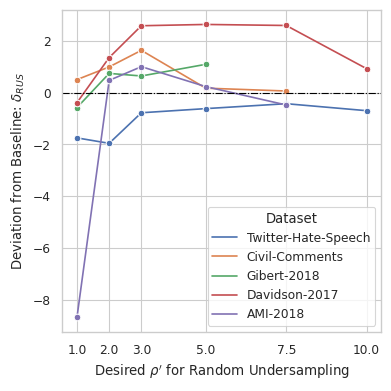

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.0,4.0))
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_rus, 
                hue="Dataset", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Undersampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r"Deviation from Baseline: $\delta_{RUS}$")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/RUS_trend.svg', dpi=600, bbox_inches="tight")

## Compare ROS, Augmentation

In [139]:
variant_to_check = ["baseline", "sampling_modifiedRS_oversampling", "augmentation_bert", "augmentation_abusive_lexicon", "augmentation_external_data"]
which_data_to_check = (df_all_agg_results["variant"].isin(variant_to_check))
metrics_to_check = ["test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]
df_mean_ros_aug = df_all_agg_results[which_data_to_check][["data_name", "variant", ] + metrics_to_check]
df_mean_ros_aug

,data_name,variant,test_f1_macro,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
4,ami,augmentation_bert,54.62,66.38,82.02,42.11,55.01,27.60
5,ami,baseline,54.65,66.18,85.77,43.97,53.59,23.75
8,ami,augmentation_abusive_lexicon,55.61,66.66,85.02,44.88,55.60,25.88
9,ami,sampling_modifiedRS_oversampling,55.70,65.73,84.46,45.08,55.18,28.04
17,civil-comments,augmentation_abusive_lexicon,75.67,95.84,55.50,0.00,0.00,0.00
18,civil-comments,sampling_modifiedRS_oversampling,75.85,96.28,55.42,0.00,0.00,0.00
19,civil-comments,augmentation_bert,75.88,96.08,55.68,0.00,0.00,0.00
20,civil-comments,baseline,75.99,95.94,56.04,0.00,0.00,0.00
21,civil-comments,augmentation_external_data,76.44,96.41,56.48,0.00,0.00,0.00
24,cmsb-tsd,baseline,84.36,95.74,72.98,0.00,0.00,0.00


In [140]:
df_mean_ros_aug_by_data = pd.DataFrame(columns=["variant"] + sum([[f"{data_name}_{metric}" for metric in metrics_to_check] for data_name in data_names], []))
df_mean_ros_aug_by_data["variant"] = variant_to_check
for data_name in data_names:
    for variant in variant_to_check:
        conditions = (df_mean_ros_aug["data_name"] == data_name) & (df_mean_ros_aug["variant"] == variant)
        if len(df_mean_ros_aug[conditions]) > 0:
            value = df_mean_ros_aug.loc[conditions, "test_f1_macro"].values[0]
            df_mean_ros_aug_by_data.loc[df_mean_ros_aug_by_data["variant"] == variant, f"{data_name}_test_f1_macro"] = value
            for i in range(5):
                value = df_mean_ros_aug.loc[conditions, f"test_f1_per_label_{i}"].values[0]
                df_mean_ros_aug_by_data.loc[df_mean_ros_aug_by_data["variant"] == variant, f"{data_name}_test_f1_per_label_{i}"] = value
df_mean_ros_aug_by_data.to_csv("compare_ROS_augmentation.csv", index=False)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


### Weighted Cross Entropy

In [29]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "val_f1_per_label_1"].values[0]
    return row['val_f1_per_label_1'] - baseline_value
df_mean_wce["pos_f1_delta"] = df_mean_wce.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_wce["data_name"] = df_mean_wce["data_name"].map(data_name_orig2display)
df_mean_wce

,data_name,wce_alpha,val_f1_macro,val_f1_per_label_0,val_f1_per_label_1,pos_f1_delta
61,Twitter-Hate-Speech,0.1,86.94,98.37,75.51,-2.36
62,Twitter-Hate-Speech,0.25,87.21,98.31,76.10,-1.77
63,Twitter-Hate-Speech,0.75,87.60,98.33,76.88,-0.99
64,Twitter-Hate-Speech,0.9,87.48,98.31,76.65,-1.22
65,Twitter-Hate-Speech,0.93,87.42,98.25,76.59,-1.28
66,Twitter-Hate-Speech,0.99,82.73,97.02,68.44,-9.43
166,Civil-Comments,0.1,76.09,96.73,55.45,-4.36
167,Civil-Comments,0.25,77.49,96.98,58.00,-1.81
168,Civil-Comments,0.75,79.66,96.93,62.39,2.58
169,Civil-Comments,0.9,79.22,96.58,61.85,2.04


In [30]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] > 2)
df_mean_wce_multi = df_all_mean_results[conditions][["data_name", "wce_alpha", "val_f1_macro", 'val_f1_per_label_0', 'val_f1_per_label_1', 'val_f1_per_label_2', 'val_f1_per_label_3', 'val_f1_per_label_4']]
df_mean_wce_multi["data_name"] = df_mean_wce_multi["data_name"].map(data_name_orig2display)
df_mean_wce_multi

,data_name,wce_alpha,val_f1_macro,val_f1_per_label_0,val_f1_per_label_1,val_f1_per_label_2,val_f1_per_label_3,val_f1_per_label_4
571,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",63.22,84.11,57.49,76.34,34.94,0.00
572,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",59.68,82.47,52.86,77.17,26.21,0.00
573,Founta-2018,"(0.5, 0.6, 0.1, 0.6)",61.85,85.94,53.71,72.09,35.66,0.00
574,Founta-2018,"(0.5, 0.6, 0.2, 0.4)",62.64,86.14,54.45,76.97,33.01,0.00
575,Founta-2018,"(0.9, 0.1, 0.3, 0.7)",58.33,87.40,40.78,74.76,30.38,0.00
665,Davidson-2017,"(0.1, 0.7, 0.9)",68.48,23.35,94.19,87.90,0.00,0.00
666,Davidson-2017,"(0.5, 0.6, 0.1)",74.08,41.61,94.01,86.62,0.00,0.00
667,Davidson-2017,"(0.9, 0.1, 0.3)",76.57,47.52,93.67,88.51,0.00,0.00
668,Davidson-2017,"(1.2, 0.1, 0.4)",75.85,46.08,93.58,87.89,0.00,0.00
748,AMI-2018,"(0.1, 0.1, 0.1, 0.2, 0.9)",50.91,77.75,39.27,32.63,53.13,51.74


In [40]:
# wce_alpha_unique = df_mean_wce.wce_alpha.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.878, 0.888, 0.9, 0.93, 0.99]
# data_name_unique = df_mean_wce.data_name.unique().tolist()
data_name_unique = [data_name_orig2display[data_name] for data_name in ["twitter-hate-speech-tsa", "gibert-2018-shs", "us-election-2020"]]
df_wce_delta_by_data = pd.DataFrame(columns=["wce_alpha"] + sum([[f"{data_name}_macro_f1", 
                                                                    # f"{data_name}_f1_non-hate", 
                                                                    f"{data_name}_f1_hate"] for data_name in data_name_unique], []))
df_wce_delta_by_data["wce_alpha"] = wce_alpha_unique
for data_name in data_name_unique:
    for wce_alpha in wce_alpha_unique:
        conditions = (df_mean_wce["data_name"] == data_name) & (df_mean_wce["wce_alpha"] == wce_alpha)
        if len(df_mean_wce[conditions]) > 0:
            value = df_mean_wce.loc[conditions, "val_f1_macro"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_macro_f1"] = value
            # value = df_mean_wce.loc[conditions, "val_f1_per_label_0"].values[0]
            # df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_non-hate"] = value
            value = df_mean_wce.loc[conditions, "val_f1_per_label_1"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_hate"] = value
df_wce_delta_by_data = df_wce_delta_by_data.sort_values(by=['wce_alpha']).reset_index(drop=True)
df_wce_delta_by_data

,wce_alpha,Twitter-Hate-Speech_macro_f1,Twitter-Hate-Speech_f1_hate,Gibert-2018_macro_f1,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_hate
0,0.100,86.94,75.51,77.69,59.97,57.94,21.45
1,0.250,87.21,76.1,78.43,61.6,80.44,65.13
2,0.750,87.6,76.88,78.98,63.09,79.75,64.08
3,0.878,NaN,NaN,NaN,NaN,79.47,63.47
4,0.888,NaN,NaN,79.72,64.04,NaN,NaN
5,0.900,87.48,76.65,79.1,63.37,81.16,66.7
6,0.930,87.42,76.59,NaN,NaN,NaN,NaN
7,0.990,82.73,68.44,76.09,58.73,32.5,34.29


### Focal Loss

In [7]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["num_classes"] == 2)
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            value = df_mean_fl.loc[conditions, "val_f1_per_label_0"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_non-hate"] = value
            value = df_mean_fl.loc[conditions, "val_f1_per_label_1"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_hate"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data

,fl_gamma,Twitter-Hate-Speech_macro_f1,Twitter-Hate-Speech_f1_non-hate,Twitter-Hate-Speech_f1_hate,Civil-Comments_macro_f1,Civil-Comments_f1_non-hate,Civil-Comments_f1_hate,Gibert-2018_macro_f1,Gibert-2018_f1_non-hate,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_non-hate,US-Election-2020_f1_hate,CMSB_macro_f1,CMSB_f1_non-hate,CMSB_f1_hate
0,0.1,88.10,98.40,77.81,78.74,96.77,60.70,79.31,95.60,63.02,81.92,95.56,68.28,84.96,95.73,74.19
1,0.2,87.86,98.36,77.35,78.80,96.69,60.91,79.70,95.39,64.02,81.60,96.08,67.11,85.31,95.73,74.88
2,0.5,88.21,98.45,77.97,79.42,96.90,61.94,79.53,95.55,63.51,80.13,95.77,64.49,85.23,95.90,74.56
3,1.0,87.72,98.38,77.06,77.43,96.71,58.15,78.71,95.47,61.96,80.78,95.08,66.48,84.74,95.58,73.90
4,2.0,87.58,98.28,76.88,78.46,97.03,59.90,79.29,95.18,63.40,77.01,95.57,58.46,84.98,95.50,74.46
5,5.0,87.70,98.32,77.09,78.93,97.18,60.68,79.32,95.01,63.62,78.14,95.01,61.27,84.83,95.59,74.06


In [9]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "davidson-thon")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(3):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,Davidson-2017_macro_f1,Davidson-2017_f1_per_label_0,Davidson-2017_f1_per_label_1,Davidson-2017_f1_per_label_2
0,0.1,75.76,45.29,94.17,87.81
1,0.2,75.29,43.18,94.34,88.34
2,0.5,76.02,45.63,94.32,88.12
3,1.0,75.49,44.09,94.30,88.09
4,2.0,76.68,46.67,94.50,88.88
5,5.0,76.02,45.74,94.14,88.17


In [10]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "founta-2018-thas")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(4):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,Founta-2018_macro_f1,Founta-2018_f1_per_label_0,Founta-2018_f1_per_label_1,Founta-2018_f1_per_label_2,Founta-2018_f1_per_label_3
0,0.1,62.30,86.55,52.49,76.89,33.27
1,0.2,62.46,86.22,54.31,77.37,31.95
2,0.5,62.45,86.98,53.22,77.90,31.70
3,1.0,61.99,86.65,54.80,76.77,29.75
4,2.0,62.28,86.54,53.85,76.73,32.00
5,5.0,61.79,84.84,54.97,75.51,31.84


In [11]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "ami")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3", "val_f1_per_label_4"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(5):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,AMI-2018_macro_f1,AMI-2018_f1_per_label_0,AMI-2018_f1_per_label_1,AMI-2018_f1_per_label_2,AMI-2018_f1_per_label_3,AMI-2018_f1_per_label_4
0,0.1,52.93,75.64,45.58,35.45,54.40,53.60
1,0.2,54.00,76.50,47.97,33.89,52.37,59.28
2,0.5,52.46,76.90,48.44,35.76,51.19,50.02
3,1.0,51.67,77.12,47.95,35.19,50.88,47.21
4,2.0,49.45,76.47,39.76,29.53,55.63,45.86
5,5.0,50.11,77.47,39.21,26.72,53.59,53.54


In [92]:
conditions = (df_all_mean_results["variant"] == "wfl") & (df_all_mean_results["num_classes"] == 2)
df_mean_wfl = df_all_mean_results[conditions][["data_name", "fl_gamma", "wce_alpha", "test_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_wfl.fl_gamma.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.9, 0.99]
data_name_unique = df_mean_wfl.data_name.unique().tolist()
df_mean_wfl_by_data = pd.DataFrame()
df_mean_wfl_by_data["fl_gamma"] = fl_gamma_unique * len(wce_alpha_unique)
df_mean_wfl_by_data["wce_alpha"] = sum([[alpha] * len(fl_gamma_unique) for alpha in wce_alpha_unique], [])
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        for wce_alpha in wce_alpha_unique:
            value_is_from_where = (df_mean_wfl["data_name"] == data_name) & (df_mean_wfl["fl_gamma"] == fl_gamma) & (df_mean_wfl["wce_alpha"] == wce_alpha)
            if len(df_mean_wfl[value_is_from_where]) > 0:
                value = df_mean_wfl.loc[value_is_from_where, "test_f1_macro"].values[0]
                where_to_assign = (df_mean_wfl_by_data["fl_gamma"] == fl_gamma) & (df_mean_wfl_by_data["wce_alpha"] == wce_alpha)
                df_mean_wfl_by_data.loc[where_to_assign, f"{data_name}_macro_f1"] = value
df_mean_wfl_by_data = df_mean_wfl_by_data.sort_values(by=['fl_gamma', 'wce_alpha']).reset_index(drop=True)
df_mean_wfl_by_data

,fl_gamma,wce_alpha,Twitter-Hate-Speech_macro_f1,Gibert-2018_macro_f1,US-Election-2020_macro_f1,CMSB_macro_f1
0,0.1,0.10,86.49,74.17,63.41,83.11
1,0.1,0.25,87.39,75.60,76.24,84.47
2,0.1,0.75,86.45,76.78,74.74,84.93
3,0.1,0.90,86.78,76.65,75.69,84.23
4,0.1,0.99,78.33,75.36,NaN,79.66
5,0.2,0.10,87.44,74.70,47.41,84.76
6,0.2,0.25,87.05,76.40,73.39,84.40
7,0.2,0.75,86.96,76.42,76.71,84.68
8,0.2,0.90,87.09,76.83,79.77,84.47
9,0.2,0.99,79.79,74.55,NaN,80.44


In [140]:
data_no_clear_fl = ["us-election-2020", "cmsb-tsd", "founta-2018-thas"]
which_data_to_check = (((df_all_mean_results["variant"] == "fl"))
                        # & (~df_all_mean_results["data_name"].isin(data_no_clear_fl))
                        )
df_mean_fl = df_all_mean_results[which_data_to_check][["data_name", "fl_gamma", "val_f1_macro"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "val_f1_macro"].values[0]
    return row['val_f1_macro'] - baseline_value
df_mean_fl["val_f1_macro_delta"] = df_mean_fl.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)
df_mean_fl = df_mean_fl.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl

,Dataset,fl_gamma,val_f1_macro,val_f1_macro_delta
39,Twitter-Hate-Speech,0.1,88.10,-0.01
40,Twitter-Hate-Speech,0.2,87.86,-0.25
41,Twitter-Hate-Speech,0.5,88.21,0.10
42,Twitter-Hate-Speech,1.0,87.72,-0.39
43,Twitter-Hate-Speech,2.0,87.58,-0.53
44,Twitter-Hate-Speech,5.0,87.70,-0.41
144,Civil-Comments,0.1,78.74,0.49
145,Civil-Comments,0.2,78.80,0.55
146,Civil-Comments,0.5,79.42,1.17
147,Civil-Comments,1.0,77.43,-0.82


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


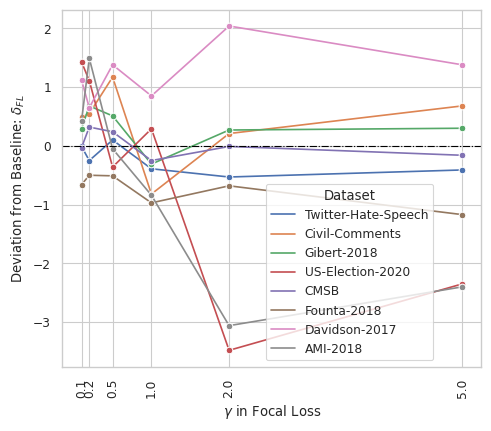

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(5,4.4))
sns.lineplot(x="fl_gamma", y="val_f1_macro_delta", data=df_mean_fl, hue="Dataset", marker="o", ax=ax)
gamma_ticks = df_mean_fl.fl_gamma.unique().tolist()
ax.set_xticks(gamma_ticks, labels=gamma_ticks, rotation=90)
ax.set_xlabel(r"$\gamma$ in Focal Loss")
# # delta_ticks = [y for y in list(range(-2, 8, 2))]
# # ax.set_yticks(delta_ticks)

ax.set_ylabel(r"Deviation from Baseline: $\delta_{FL}$")
# # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
sns.move_legend(ax, "lower right", bbox_to_anchor=(.9, 0.)) #
ax.figure.tight_layout()
ax.figure.savefig('results/FL_trend.svg', dpi=600, bbox_inches="tight")

#### Why are some data not good in FL?

In [24]:
# check if unpromising results in fl is because the negative class was improved
data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_not_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
338,us-election-2020,0.1,81.92,74.44,99.82,98.72,95.56,68.28,94.48,54.40
339,us-election-2020,0.2,81.60,77.82,99.57,96.91,96.08,67.11,95.76,59.87
340,us-election-2020,0.5,80.13,72.89,99.66,97.57,95.77,64.49,95.11,50.67
341,us-election-2020,1.0,80.78,73.88,99.64,97.46,95.08,66.48,94.28,53.48
342,us-election-2020,2.0,77.01,74.45,99.20,94.01,95.57,58.46,95.79,53.10
343,us-election-2020,5.0,78.14,72.41,99.21,94.24,95.01,61.27,94.82,50.00
495,waseem-and-hovy-2016,0.1,86.53,86.77,99.41,98.36,92.94,80.11,93.22,80.32
496,waseem-and-hovy-2016,0.2,86.44,86.95,99.39,98.31,92.87,80.02,93.23,80.68
497,waseem-and-hovy-2016,0.5,86.16,86.50,99.33,98.16,92.46,79.85,92.75,80.25
498,waseem-and-hovy-2016,1.0,86.08,86.69,99.37,98.25,92.82,79.34,93.19,80.19


In [30]:
# check if unpromising results in fl is because the negative class was improved
data_good_in_fl = ["founta-2018-thas", "ami"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", "train_f1_per_label_2", "train_f1_per_label_3", "train_f1_per_label_4",
                    "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3", "val_f1_per_label_4",
                    "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,train_f1_per_label_2,train_f1_per_label_3,train_f1_per_label_4,val_f1_per_label_0,val_f1_per_label_1,val_f1_per_label_2,val_f1_per_label_3,val_f1_per_label_4,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
572,founta-2018-thas,0.1,62.30,62.92,98.47,94.16,96.66,91.46,0.00,86.55,52.49,76.89,33.27,0.00,86.39,52.00,78.56,34.73,0.00
573,founta-2018-thas,0.2,62.46,63.55,98.01,92.48,95.58,88.16,0.00,86.22,54.31,77.37,31.95,0.00,86.21,53.43,78.32,36.22,0.00
574,founta-2018-thas,0.5,62.45,62.91,97.77,91.49,95.39,87.83,0.00,86.98,53.22,77.90,31.70,0.00,86.91,52.85,78.85,33.02,0.00
575,founta-2018-thas,1.0,61.99,63.18,96.95,88.46,94.13,84.39,0.00,86.65,54.80,76.77,29.75,0.00,86.86,55.06,77.53,33.29,0.00
576,founta-2018-thas,2.0,62.28,62.93,97.24,89.33,95.27,88.20,0.00,86.54,53.85,76.73,32.00,0.00,86.54,53.50,77.19,34.47,0.00
577,founta-2018-thas,5.0,61.79,62.60,94.38,78.25,91.91,78.17,0.00,84.84,54.97,75.51,31.84,0.00,85.11,55.08,75.57,34.66,0.00
708,ami,0.1,52.93,54.25,99.56,97.64,95.85,98.99,97.56,75.64,45.58,35.45,54.40,53.60,65.13,85.09,45.69,52.34,23.02
709,ami,0.2,54.00,56.44,99.58,98.63,96.51,99.37,97.81,76.50,47.97,33.89,52.37,59.28,67.06,84.39,48.82,57.32,24.63
710,ami,0.5,52.46,54.92,99.72,99.25,98.64,99.50,100.00,76.90,48.44,35.76,51.19,50.02,65.48,85.64,46.06,55.99,21.42
711,ami,1.0,51.67,54.10,99.72,99.13,98.18,99.24,100.00,77.12,47.95,35.19,50.88,47.21,65.83,84.61,41.61,53.95,24.52


### Weighted Focal Loss

In [99]:
conditions = (df_all_mean_results["variant"] == "wfl")
df_mean_wfl = df_all_mean_results[conditions][["data_name", "wce_alpha", "fl_gamma", "val_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)
df_mean_wfl

,data_name,wce_alpha,fl_gamma,test_f1_macro
70,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.1,62.87
71,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.2,63.24
72,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.5,64.22
73,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",1.0,63.14
74,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",2.0,64.07
75,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",5.0,62.32
76,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.1,60.43
77,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.2,59.90
78,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.5,60.03
79,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",1.0,57.76


### Augmentation

In [45]:
conditions = (df_all_mean_results["variant"] == "augmentation_bert")
# data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "augmentation_rho", "augmentation_percentage", "augmentation_top_k", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_bert = df_all_mean_results[conditions][relevant_cols]
# df_mean_aug["data_name"] = df_mean_aug["data_name"].map(data_name_orig2display)
df_mean_aug_bert

,data_name,augmentation_rho,augmentation_percentage,augmentation_top_k,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
0,bretschneider-th-main,1.5,0.1,3,77.28,69.22,97.92,97.00,96.31,58.25,94.82,43.62
1,bretschneider-th-main,1.5,0.1,5,78.15,70.57,97.99,97.11,96.87,59.42,95.35,45.79
2,bretschneider-th-main,1.5,0.3,3,74.98,65.85,97.81,96.79,95.93,54.03,93.94,37.77
3,bretschneider-th-main,1.5,0.3,5,73.44,65.99,97.68,96.62,95.82,51.06,94.29,37.69
4,bretschneider-th-main,2.0,0.1,3,76.76,69.05,97.98,96.16,96.25,57.27,94.65,43.45
...,...,...,...,...,...,...,...,...,...,...,...,...
713,ami,1.5,0.3,5,52.00,51.71,99.43,99.77,76.90,44.16,65.26,84.02
714,ami,3.0,0.1,3,53.15,54.62,99.15,99.74,78.75,41.66,66.38,82.02
715,ami,3.0,0.1,5,51.48,55.38,99.30,99.34,77.20,42.07,65.98,83.82
716,ami,3.0,0.3,3,51.20,51.68,99.39,99.34,77.68,43.04,62.22,82.47


In [54]:
df_all_mean_results[df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"])]

,data_name,num_classes,data_type,size,rho,distribution,variant,sampling_modifiedRS_rho,sampling_weightedRS_percentage,augmentation_rho,...,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4,test_accuracy,test_precision_macro,test_precision_weighted,test_recall_macro,test_recall_weighted,test_auprc
8,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.0,...,30.14,0.00,0.00,0.00,87.59,59.97,91.28,66.51,87.59,58.47
9,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.2,...,35.22,0.00,0.00,0.00,88.68,62.13,91.96,70.03,88.68,60.35
10,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.5,...,31.51,0.00,0.00,0.00,87.36,60.05,91.48,68.06,87.36,59.16
18,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.0,-,-,...,49.94,0.00,0.00,0.00,92.41,70.18,93.72,77.06,92.41,67.06
19,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.2,-,-,...,47.78,0.00,0.00,0.00,92.59,70.11,93.36,74.21,92.59,66.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,1.5,-,-,...,86.69,42.01,49.83,25.82,64.13,59.05,68.73,55.57,64.13,56.60
728,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,2.0,-,-,...,76.84,44.50,55.69,31.75,61.88,62.39,68.23,55.29,61.88,56.59
729,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,3.0,-,-,...,84.46,45.08,55.18,28.04,65.07,58.58,67.51,57.03,65.07,57.98
730,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,5.0,-,-,...,82.67,46.23,56.15,26.08,64.35,59.20,67.42,55.95,64.35,57.43


In [57]:
df_all_mean_results.sampling_modifiedRS_rho.unique()

array(['-', 1.0, 1.2, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 2.5, 15.0],
      dtype=object)

In [62]:
df_all_mean_results.augmentation_rho.unique()

array([1.5, 2.0, 1.0, 1.2, '-', 3.0, 5.0, 7.5, 10.0], dtype=object)

In [75]:
data_to_check = data_names[:-1]
conditions = (df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"]) 
                & df_all_mean_results["data_name"].isin(data_to_check))
relevant_cols = ["data_name", "variant", "sampling_modifiedRS_rho", "augmentation_rho", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_ext = df_all_mean_results[conditions][relevant_cols]
def get_rho(row):
    if row["sampling_modifiedRS_rho"] != "-":
        return row["sampling_modifiedRS_rho"]
    if row["augmentation_rho"] != "-":
        return row["augmentation_rho"]
df_mean_aug_ext["rho"] = df_mean_aug_ext.apply(lambda row: get_rho(row), axis=1)
df_mean_aug_ext["data_name"] = df_mean_aug_ext["data_name"].map(data_name_orig2display)
df_mean_aug_ext = df_mean_aug_ext[["data_name", "variant", "rho"] + relevant_cols[4:]]
df_mean_aug_ext = df_mean_aug_ext.sort_values(by=['data_name', 'rho']).reset_index(drop=True)
df_mean_aug_ext.to_csv("check_external_data.csv", index=False)

## Check MLflow runs

In [ ]:
mlrun_ids = []

with open("./outputs/ami_augmentation_abusive_lexicon_seed0_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

# with open("./outputs/twitter-hate-speech-tsa_sampling_weightedRS_oversampling_seed21_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/ami_augmentation_abusive_lexicon_seed42_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]
    
# with open("./outputs/ami/ami_augmentation_bert_seed0_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

for id in mlrun_ids:
    print(id)

len(mlrun_ids)

In [169]:
ignored_ids = ['03886a4688de4e73b5964942c8becfd9', '7df28e2765bc423e846196f33cd9abb9']
import os
data_runs_dir = f'./mlruns/25'
run_ids = os.listdir(data_runs_dir)
logs = dict()
for run_id in run_ids:
    if run_id not in ignored_ids:
        ckpt_dir = f"{data_runs_dir}/{run_id}/artifacts/model_checkpoints/"
        try:
            ckpt = os.listdir(ckpt_dir)[0]
            if "undersampling" in ckpt:
                # # print(f"{run_id}")
            # if "external" in ckpt:
                # for root, _, files in os.walk(f"{data_runs_dir}/{run_id}"):
                #     key = "augmentation_rho"
                #     if key in files:
                #         with open(f"{root}/{key}", "r") as f:
                #             value = f.readlines()[-1]
                #             if value == "1.0":
                #                 print(f"{run_id}\t{ckpt}")
                            # print(f"{key} = {value}")
            #             key = "augmentation_percentage"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "0.5":
            #                         print(run_id)
            #             key = "augmentation_bert_top_k"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "1":
            #                         print(run_id)
                print(f"{run_id}")
                logs[run_id] = ckpt
        except NotADirectoryError:
            pass
# print(logs)
len(logs)

000cbad6eb1f464cbf3401bb13e91245
debc05c7b22249d6b44704d31c24cf56
bc6a104e5d0141a28c0916a7be37d0ac
71723cb8c443492cb75a3c8412543a3d
43665e90c21947f1b7863de359fbb9a3
1b1f08ed76b14c1c9dc525023af820eb
eefa7f6864ac4a5ea1933e47f6adfc23
3c68013388574d04a3c3a14fb85c72e0
c5150a62f61841c5a3cb14b6447d0626
ece841dddbda4c568d28acd84620e415
88903e1804bf4c1b80f820fe85d9c725
42acfc7a82e44dd1bbfd1e1305092880


12

In [39]:
("a", 1) in [("a", 1), ("b", 2)]

True

In [28]:
import ast
ckpt = "davidson-thon-augmentation_bert-Trial_6augmentation_percentage=0.3augmentation_top_k=3-seed42-epoch=00-val_f1_macro=0.72.ckpt"
ast.literal_eval(ckpt.split("epoch=")[1][:2])

0